In [1]:
from tensorflow.keras.models import load_model
from tqdm.notebook import tqdm
import cifar10
import dnn
import os.path
import graph_tool as gt
import nn2graph
import numpy as np
import pandas as pd
import statsmodels.stats as stats
import matplotlib
matplotlib.rcParams.update({'font.size': 18})
import matplotlib.pyplot as plt
import seaborn as sns

#### Convert neural network to graph

In [2]:
N = 5000
num_runs = 3
rand_inds = cifar10.subsample_test(N)
def get_activation_networks(inputs, run=1, num_layers=4, num_epochs=10):
    from tensorflow.keras.layers import Dense
    model = dnn.load_run(run+1, num_layers=num_layers, num_epochs=num_epochs)
    layer_sizes = [mnist.X_test.shape[-1]] + [layer.units for layer in model.layers if isinstance(layer, Dense)]
    _, g_xs = nn2graph.dense_activations_to_graph(model, inputs)
    return g_xs, layer_sizes

def get_layer_sizes(inputs, num_layers=4, num_outputs=10, hidden_dims=64):
    layer_sizes = [inputs[0].shape[-1]]
    for i in range(num_layers):
        layer_sizes.append(hidden_dims)
    layer_sizes.append(num_outputs)
    return layer_sizes

#### Mean weighted degree distributions per class

In [8]:
def compute_mean_weighted_degrees(inputs):
    mean_weighted_degrees = []
    for i in tqdm(range(num_runs)):
        g_xs, layer_sizes = get_activation_networks(mnist.X_test[rand_inds], run=i)
        mean_weighted_degrees.append([float(g.vp['degree'].a[inputs.shape[-1]:].mean()) for g in g_xs])
        del g_xs
    mean_weighted_degrees = np.array(mean_weighted_degrees).mean(axis=0)
    return mean_weighted_degrees
    
def compute_mean_weighted_degrees_by_layer(inputs):
    mean_weighted_degrees_by_layer = []
    for i in tqdm(range(num_runs)):
        g_xs, layer_sizes = get_activation_networks(mnist.X_test[rand_inds], run=i)
        layer_mean_degrees = []
        for i, (l, st) in enumerate(zip(layer_sizes, np.cumsum(layer_sizes))):
            mean_weighted_degrees = [float(g.vp['degree'].a[st-l:st].mean()) for g in g_xs]
            layer_mean_degrees.append(mean_weighted_degrees)
        mean_weighted_degrees_by_layer.append(np.array(layer_mean_degrees))
        del g_xs
    mean_weighted_degrees_by_layer = np.array(mean_weighted_degrees_by_layer).mean(axis=0)
    return mean_weighted_degrees_by_layer

In [9]:
mean_weighted_degrees = compute_mean_weighted_degrees(mnist.X_test[rand_inds])
mean_weighted_degrees_by_layer = compute_mean_weighted_degrees_by_layer(mnist.X_test[rand_inds])

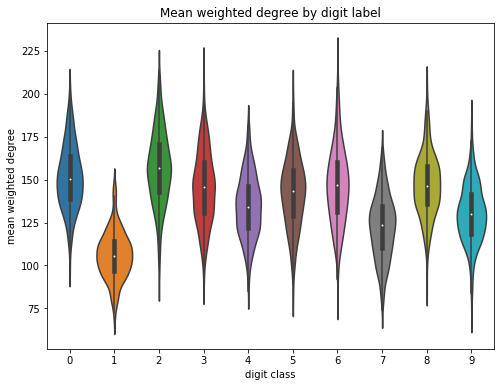

In [10]:
g_xs_mean_degree_by_class = pd.DataFrame({'digit class': mnist.test_labels[rand_inds],
                                          'mean weighted degree': mean_weighted_degrees})
plt.figure(figsize=(8,6))
sns.violinplot(x='digit class', y='mean weighted degree', data=g_xs_mean_degree_by_class)
plt.title('Mean weighted degree by digit label')
plt.show()

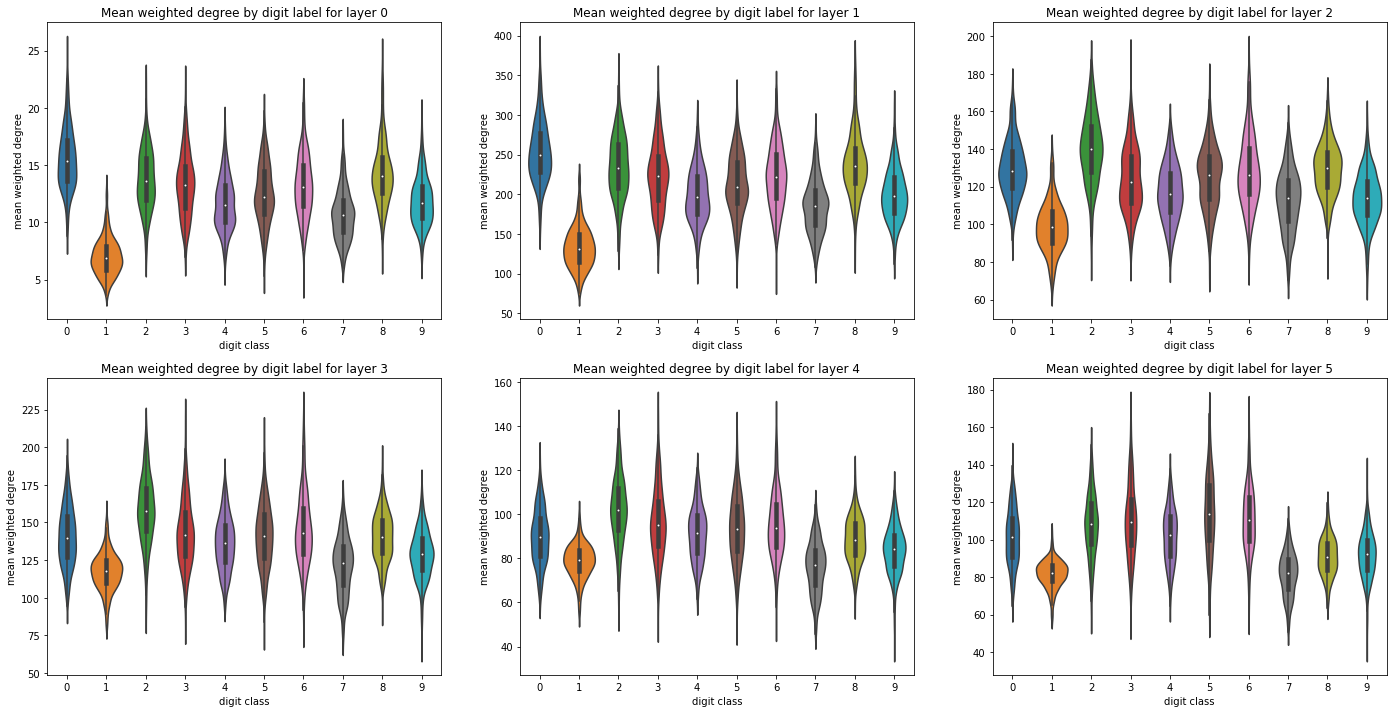

In [11]:
fig, axs = plt.subplots(2, 3, figsize=(3*8,2*6))
for i in range(6):
    ax = axs[0 if i < 3 else 1, i%3]
    g_xs_mean_degree_by_class_ = pd.DataFrame({'digit class': mnist.test_labels[rand_inds],
                                               'mean weighted degree': mean_weighted_degrees_by_layer[i]})
    sns.violinplot(x='digit class', y='mean weighted degree', data=g_xs_mean_degree_by_class_,
                   ax=ax)
    ax.set_title('Mean weighted degree by digit label for layer {}'.format(i))
plt.show()

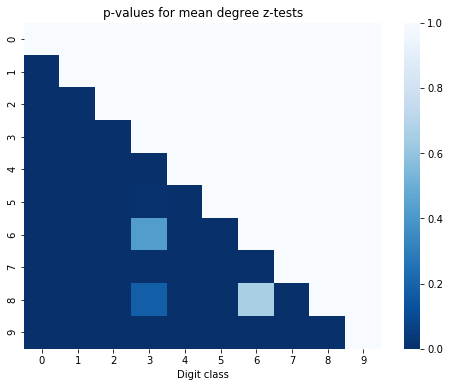

In [12]:
from statsmodels.stats.weightstats import ztest

groups_by_class = g_xs_mean_degree_by_class.groupby('digit class').groups.items()
p_vals = np.ones((10,10))
for i, (c_1, inds_1) in enumerate(groups_by_class):
    for j, (c_2, inds_2) in enumerate(groups_by_class):
        if j >= i:
            continue
        sample_1 = g_xs_mean_degree_by_class.loc[inds_1, 'mean weighted degree']
        sample_2 = g_xs_mean_degree_by_class.loc[inds_2, 'mean weighted degree']
        z, p = ztest(sample_1, sample_2)
        p_vals[i, j] = p
plt.figure(figsize=(8,6))
sns.heatmap(p_vals, cmap='Blues_r')
plt.title('p-values for mean degree z-tests')
plt.xlabel('Digit class')
plt.show()

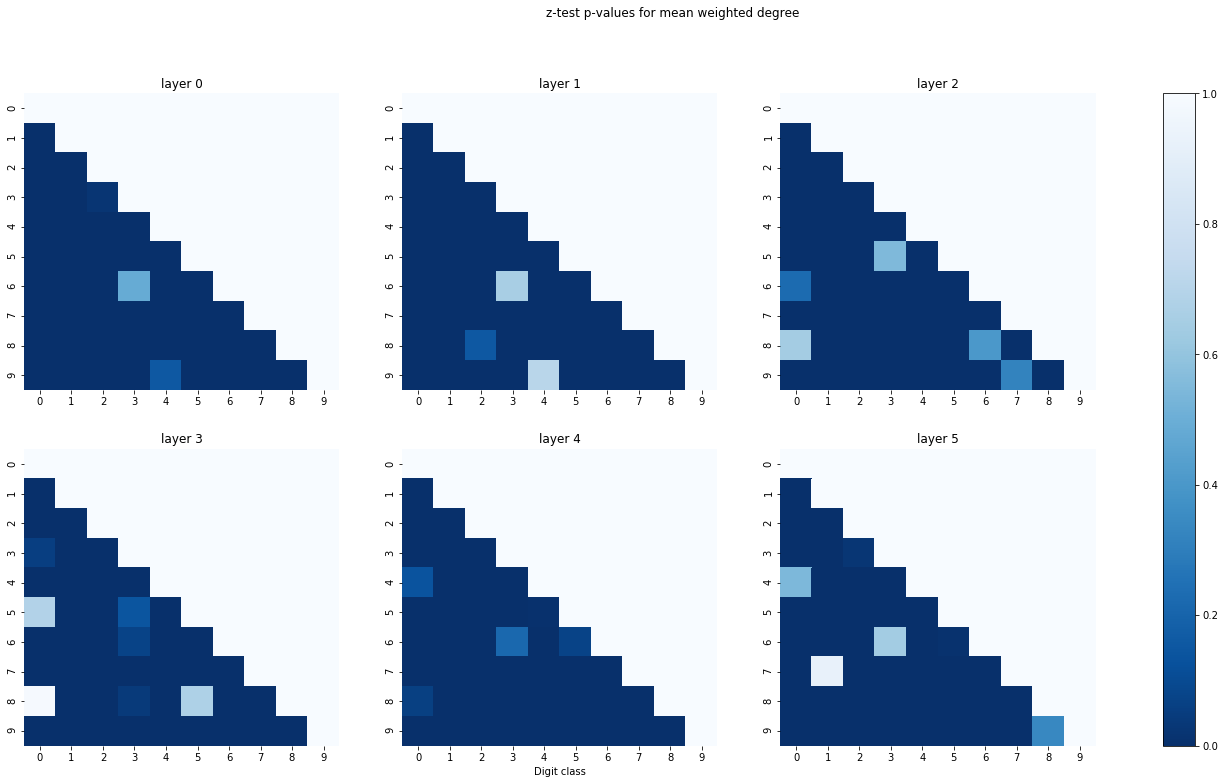

In [13]:
fig, axs = plt.subplots(2, 3, figsize=(3*8,2*6))
for k in range(6):
    ax = axs[0 if k < 3 else 1, k%3]
    g_xs_mean_degree_by_class_l = pd.DataFrame({'digit class': mnist.test_labels[rand_inds],
                                                'mean weighted degree': mean_weighted_degrees_by_layer[k]})
    groups_by_class = g_xs_mean_degree_by_class_l.groupby('digit class').groups.items()
    p_vals = np.ones((10,10))
    for i, (c_1, inds_1) in enumerate(groups_by_class):
        for j, (c_2, inds_2) in enumerate(groups_by_class):
            if j >= i:
                continue
            sample_1 = g_xs_mean_degree_by_class_l.loc[inds_1, 'mean weighted degree']
            sample_2 = g_xs_mean_degree_by_class_l.loc[inds_2, 'mean weighted degree']
            z, p = ztest(sample_1, sample_2)
            p_vals[i, j] = p
    hmap = sns.heatmap(p_vals, cmap='Blues_r', ax=ax, cbar=False)
    ax.set_title('layer {}'.format(k))
    if k == 4:
        ax.set_xlabel('Digit class')
plt.colorbar(hmap.get_children()[0], ax=axs)
plt.suptitle('z-test p-values for mean weighted degree')
plt.show()

#### Mean weighted degrees vs number of active inputs

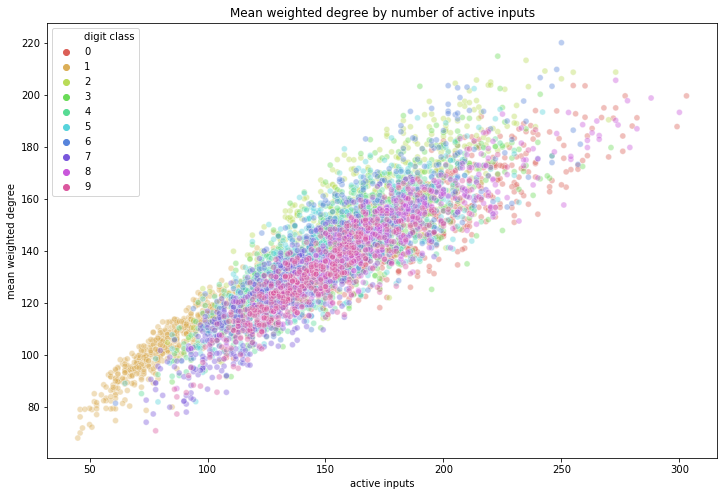

In [15]:
g_xs_degree_by_inputs = pd.DataFrame({'active inputs': np.sum(mnist.X_test[rand_inds], axis=1),
                                      'digit class': mnist.test_labels[rand_inds],
                                      'mean weighted degree': mean_weighted_degrees})
plt.figure(figsize=(12,8))
sns.scatterplot(x='active inputs', y='mean weighted degree', hue='digit class',
                palette=sns.color_palette('hls', 10), alpha=0.4,
                data=g_xs_degree_by_inputs)
plt.title('Mean weighted degree by number of active inputs')
plt.show()

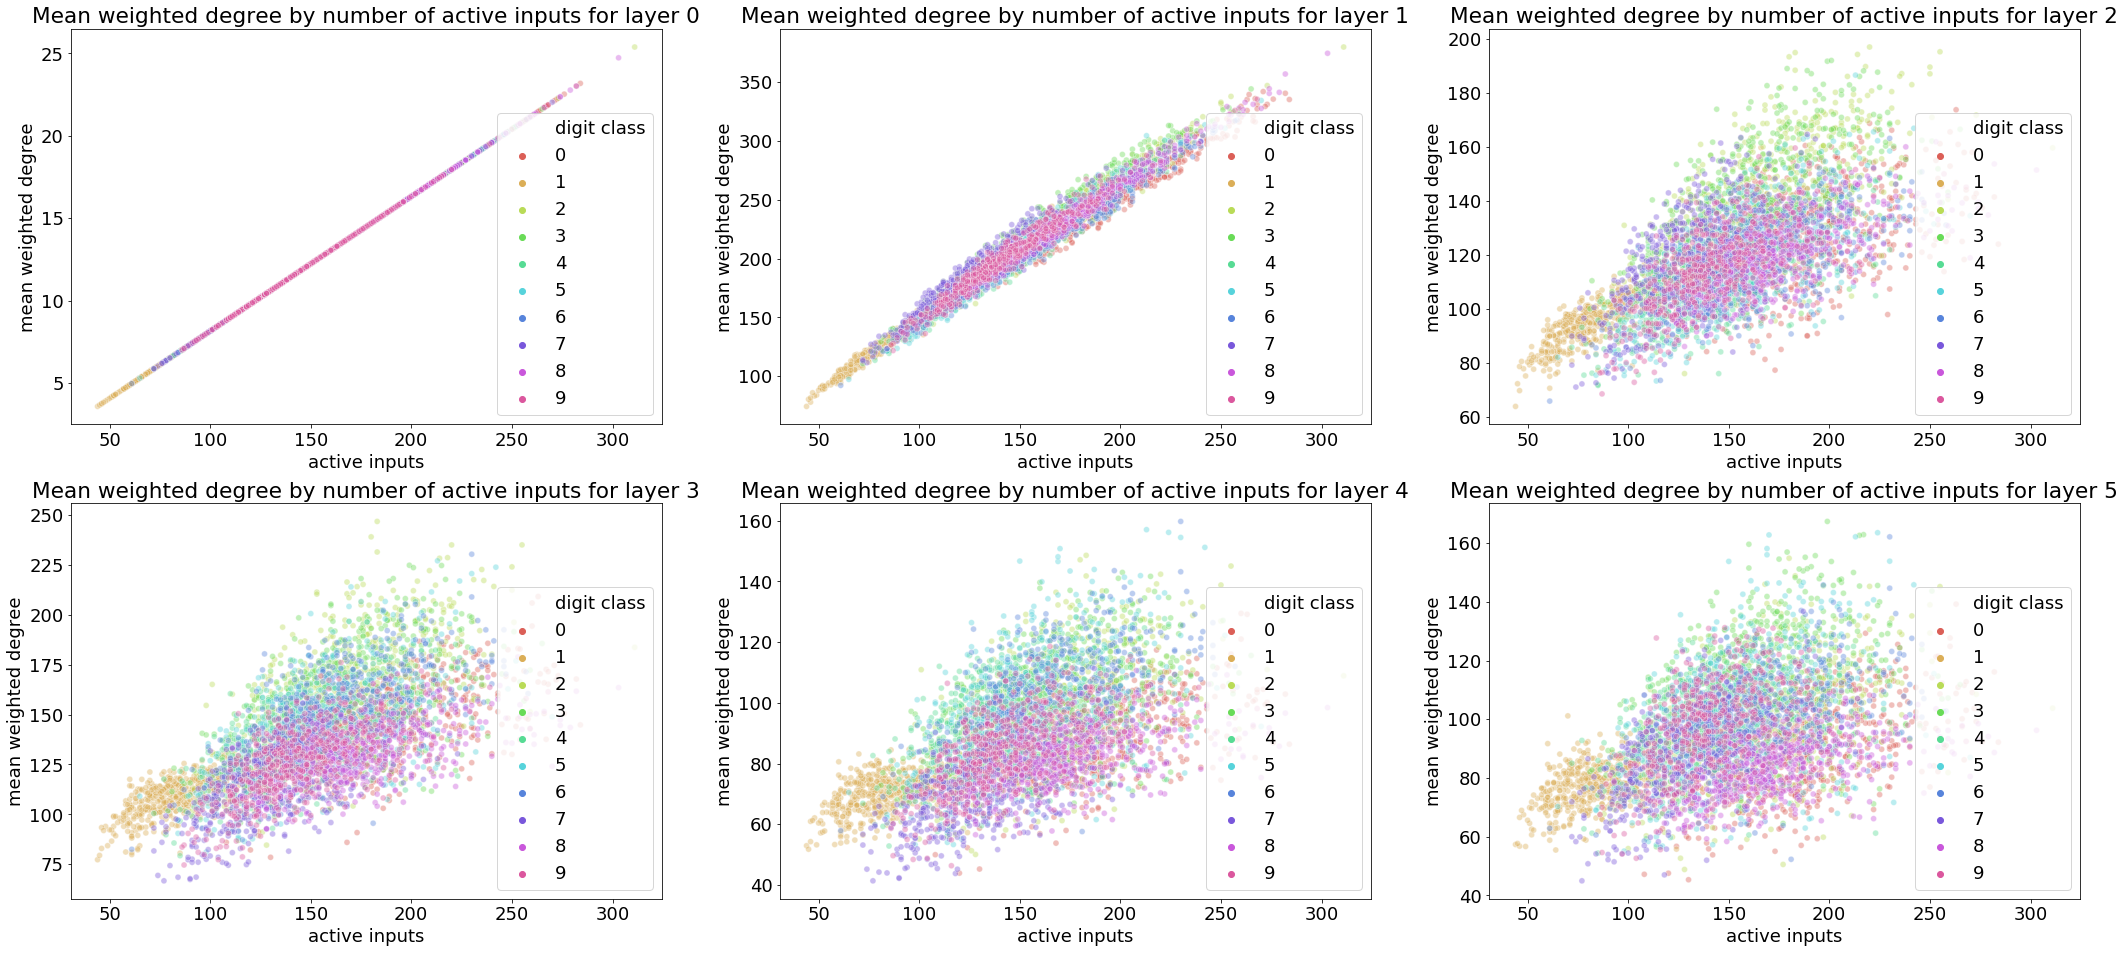

In [19]:
layer_sizes = [784, 64, 64, 64, 64, 10]
fig, axs = plt.subplots(2, 3, figsize=(3*12,2*8))
for i, (l, st) in enumerate(zip(layer_sizes, np.cumsum(layer_sizes))):
    ax = axs[0 if i < 3 else 1, i%3]
    g_xs_mean_degree_vs_inputs = pd.DataFrame({'active inputs': np.sum(mnist.X_test[rand_inds], axis=1),
                                               'digit class': mnist.test_labels[rand_inds],
                                               'mean weighted degree': [float(g.vp['degree'].a[st-l:st].mean()) for g in g_xs]})
    sns.scatterplot(x='active inputs', y='mean weighted degree', hue='digit class',
                    palette=sns.color_palette('hls', 10), alpha=0.4,
                    data=g_xs_mean_degree_vs_inputs,
                    ax=ax)
    ax.set_title('Mean weighted degree by number of active inputs for layer {}'.format(i))
plt.show()

In [20]:
from scipy.spatial.distance import pdist, squareform
def deg_pdf(g):
    degs = g.vp['degree'].a
    pdf = degs / np.sum(degs)
    return pdf
N = 1000
sub_inds = np.concatenate([np.random.choice(np.where(mnist.test_labels[rand_inds] == c)[0], N // 10, replace=False) for c in range(10)], axis=0)
labels, pdfs = zip(*[(mnist.test_labels[rand_inds[i]], deg_pdf(g_xs[i])) for i in sub_inds])
labels, pdfs = np.array(labels), np.array(pdfs)
js_dists = squareform(pdist(pdfs, metric='jensenshannon'))
avg_dists = np.ones((10,10))
for i in range(10):
    for j in range(10):
        avg_dists[i,j] = np.mean(js_dists[i*100:(i+1)*100,j*100:(j+1)*100])

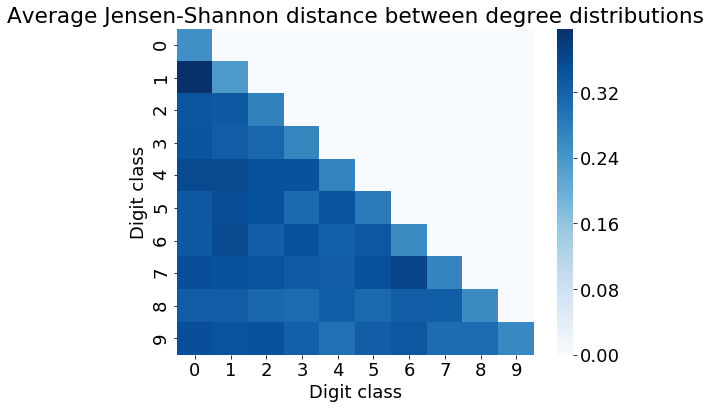

In [23]:
plt.figure(figsize=(8,6))
sns.heatmap(avg_dists*np.tril(np.ones((10,10))), cmap='Blues')
plt.title('Average Jensen-Shannon distance between degree distributions')
plt.xlabel('Digit class')
plt.ylabel('Digit class')
plt.show()

In [22]:
# from graph_tool.centrality import eigenvector
# eig_max, eig_vp = eigenvector(g, weight=g.ep['weight'], max_iter=1.0E5)
# eig_centralities = [(g.vertex_index[v], eig_vp[v]) for v in g.vertices()]
# vs_in = [v for v,_ in eig_centralities if v < input_dims]
# eigs_in = [eigc for v, eigc in eig_centralities if v < input_dims]
# vs1 = [v for v,_ in eig_centralities if v >= input_dims and v < input_dims+hidden_dims]
# eigs1 = [eigc for v, eigc in eig_centralities if v >= input_dims and v < input_dims+hidden_dims]
# vs2 = [v for v,_ in eig_centralities if v >= input_dims+hidden_dims and v < input_dims+2*hidden_dims]
# eigs2 = [eigc for v, eigc in eig_centralities if v >= input_dims+hidden_dims and v < input_dims+2*hidden_dims]
# vs3 = [v for v,_ in eig_centralities if v >= input_dims+2*hidden_dims and v < input_dims+3*hidden_dims]
# eigs3 = [eigc for v, eigc in eig_centralities if v >= input_dims+2*hidden_dims and v < input_dims+3*hidden_dims]
# vs4 = [v for v,_ in eig_centralities if v >= input_dims+3*hidden_dims and v < input_dims+4*hidden_dims]
# eigs4 = [eigc for v, eigc in eig_centralities if v >= input_dims+3*hidden_dims and v < input_dims+4*hidden_dims]
# vs_out = [v for v,_ in eig_centralities if v >= input_dims+4*hidden_dims]
# eigs_out = [eigc for v, eigc in eig_centralities if v >= input_dims+4*hidden_dims]
# plt.figure(figsize=(16,6))
# plt.subplot(1,2,1)
# plt.scatter(vs_in, eigs_in, c='gray')
# plt.scatter(vs1, eigs1, c='r')
# plt.scatter(vs2, eigs2, c='b')
# plt.scatter(vs3, eigs3, c='g')
# plt.scatter(vs4, eigs4, c='c')
# plt.scatter(vs_out, eigs_out, c='m')
# plt.legend(['inputs', 'layer 1', 'layer 2', 'layer 3', 'layer 4', 'output'])
# plt.xlabel('vertex label')
# plt.ylabel('eigenvector centrality')
# plt.title('Hidden layers + inputs')
# plt.subplot(1,2,2)
# plt.scatter(vs1, eigs1, c='r')
# plt.scatter(vs2, eigs2, c='b')
# plt.scatter(vs3, eigs3, c='g')
# plt.scatter(vs4, eigs4, c='c')
# plt.scatter(vs_out, eigs_out, c='m')
# plt.legend(['layer 1', 'layer 2', 'layer 3', 'layer 4', 'output'])
# plt.xlabel('vertex label')
# plt.ylabel('eigenvector centrality')
# plt.title('Hidden layers only')
# plt.suptitle('Eigenvector centrality vs. nodes')
# plt.show()